In [1]:
import pandas as pd
import sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

Dataframe from MDA_merge_data.ipynb is loaded, datetime column is dropped in order to run model.

In [2]:
df = pd.read_csv("C:\\Users\Arthur\hello\\final_df.csv", delimiter=";")
#select only three locations close to Oude Markt
df = df[df['object_id']<255442]
df['255439'] = df['object_id']==255439
df['255440'] = df['object_id']==255440
df['255441'] = df['object_id']==255441
df = df.sort_values(by=['result_timestamp','object_id'])
df

,object_id,result_timestamp,laeq,date,time,hour,weekday,month,weekend,day_time,...,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3,255439,255440,255441
272166,255441,2022-01-01 00:00:00,63.267554,2022-01-01,00:00:00,0,Saturday,1,True,Saturday 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True
272170,255441,2022-01-01 00:10:00,60.254000,2022-01-01,00:10:00,0,Saturday,1,True,Saturday 00:10:00,...,-48.0,0.04,0.0,13.28,13.28,13.223,13.23639,False,False,True
272174,255441,2022-01-01 00:20:00,55.143907,2022-01-01,00:20:00,0,Saturday,1,True,Saturday 00:20:00,...,45.0,0.02,0.0,13.28,13.28,13.223,13.16699,False,False,True
272178,255441,2022-01-01 00:30:00,58.230167,2022-01-01,00:30:00,0,Saturday,1,True,Saturday 00:30:00,...,-52.0,0.04,0.0,13.28,13.28,13.223,13.19886,False,False,True
272182,255441,2022-01-01 00:40:00,54.220466,2022-01-01,00:40:00,0,Saturday,1,True,Saturday 00:40:00,...,34.0,0.02,0.0,13.28,13.28,13.223,13.16699,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332425,255441,2022-12-31 23:10:00,53.712833,2022-12-31,23:10:00,23,Saturday,12,True,Saturday 23:10:00,...,-9.0,0.40,0.0,16.61,16.61,16.553,16.52797,False,False,True
332431,255441,2022-12-31 23:20:00,55.333167,2022-12-31,23:20:00,23,Saturday,12,True,Saturday 23:20:00,...,5.0,0.29,0.0,16.61,16.61,16.553,16.57995,False,False,True
332437,255441,2022-12-31 23:30:00,56.797333,2022-12-31,23:30:00,23,Saturday,12,True,Saturday 23:30:00,...,-17.0,0.15,0.0,16.51,16.51,16.453,16.44846,False,False,True
332443,255441,2022-12-31 23:40:00,61.010667,2022-12-31,23:40:00,23,Saturday,12,True,Saturday 23:40:00,...,-31.0,0.29,0.0,16.49,16.49,16.433,16.46641,False,False,True


In [3]:
df['key'] = df['object_id'].astype('str') + df['result_timestamp']
df['result_timestamp'] = pd.to_datetime(df['result_timestamp'],format='%Y-%m-%d %H:%M:%S')


In [4]:
df_noisedelay = df[['object_id','result_timestamp','laeq']]
df_noisedelay['result_timestamp'] = df_noisedelay['result_timestamp']+pd.DateOffset(hours=6)
df_noisedelay['laeq_delayed'] = df_noisedelay['laeq']
df_noisedelay['key'] = df_noisedelay['object_id'].astype('str') + df_noisedelay['result_timestamp'].astype('str')
df_noisedelay = df_noisedelay.drop(['laeq','object_id','result_timestamp'], axis=1)

df_weatherdelay = df[['object_id','result_timestamp','LC_HUMIDITY','LC_DWPTEMP','LC_n','LC_RAD','LC_RAININ',
                   'LC_DAILYRAIN','LC_WINDDIR','LC_WINDSPEED','LC_RAD60','LC_TEMP_QCL0']]
df_weatherdelay['result_timestamp'] = df_weatherdelay['result_timestamp']+pd.DateOffset(hours=6)
df_weatherdelay['key'] = df_weatherdelay['object_id'].astype('str') + df_weatherdelay['result_timestamp'].astype('str')
df_weatherdelay = df_weatherdelay.drop(['object_id','result_timestamp'], axis=1)
df = df.drop(['LC_HUMIDITY','LC_DWPTEMP','LC_n','LC_RAD','LC_RAININ',
                'LC_DAILYRAIN','LC_WINDDIR','LC_WINDSPEED','LC_RAD60','LC_TEMP_QCL0'],axis=1)


C:\Users\Arthur\AppData\Local\Temp\ipykernel_18188\3475587407.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['result_timestamp'] = df_noisedelay['result_timestamp']+pd.DateOffset(hours=6)
C:\Users\Arthur\AppData\Local\Temp\ipykernel_18188\3475587407.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['laeq_delayed'] = df_noisedelay['laeq']
C:\Users\Arthur\AppData\Local\Temp\ipykernel_18188\3475587407.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [5]:
df = pd.merge(df,df_noisedelay, on='key',validate='1:1')
df= pd.merge(df,df_weatherdelay, on='key',validate='1:1')
df_nd = df.drop(['key','object_id','result_timestamp','date','time','day_time','day_hour','LC_TEMP_QCL1','LC_TEMP_QCL2','LC_TEMP_QCL3'], axis=1)

In [6]:
df_nd.isna().sum()


laeq             0
hour             0
weekday          0
month            0
weekend          0
holiday          0
exam_period      0
255439           0
255440           0
255441           0
laeq_delayed     0
LC_HUMIDITY     19
LC_DWPTEMP      19
LC_n            19
LC_RAD          19
LC_RAININ       19
LC_DAILYRAIN    19
LC_WINDDIR      19
LC_WINDSPEED    19
LC_RAD60         1
LC_TEMP_QCL0    19
dtype: int64

In [7]:
df_nd = df_nd[df_nd.isna()['LC_HUMIDITY']==False]
df_nd.isna().sum()

laeq            0
hour            0
weekday         0
month           0
weekend         0
holiday         0
exam_period     0
255439          0
255440          0
255441          0
laeq_delayed    0
LC_HUMIDITY     0
LC_DWPTEMP      0
LC_n            0
LC_RAD          0
LC_RAININ       0
LC_DAILYRAIN    0
LC_WINDDIR      0
LC_WINDSPEED    0
LC_RAD60        0
LC_TEMP_QCL0    0
dtype: int64

In [8]:
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Monday', value=0)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Tuesday', value=1)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Wednesday', value=2)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Thursday', value=3)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Friday', value=4)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Saturday', value=5)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Sunday', value=6)

The target dataset (y) and predictor dataset (X) are created. For y, noise is converted to relative noise (proportion of max value)

In [9]:
y = df_nd["laeq"]
X = df_nd.drop(["laeq"], axis="columns")

In [10]:
#create time-sensitive split for cross-validation
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=12960,
    max_train_size=26300,
    test_size=18347,
)

In [11]:
#inspect splits
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
X.iloc[test_0]
X.iloc[train_0]

,hour,weekday,month,weekend,holiday,exam_period,255439,255440,255441,laeq_delayed,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
5,6,5,1,True,True,False,False,False,True,51.627045,90.0,11.72,38.0,0.0,0.0,0.0,0.0,0.00,0.0,13.28
6,7,5,1,True,True,False,False,False,True,52.079000,90.0,11.62,37.0,0.0,0.0,0.0,56.0,0.02,0.0,13.28
7,7,5,1,True,True,False,False,False,True,53.478833,89.0,11.58,38.0,0.0,0.0,0.0,-24.0,0.02,0.0,13.28
8,7,5,1,True,True,False,False,False,True,51.713333,89.0,11.50,37.0,0.0,0.0,0.0,-50.0,0.08,0.0,13.28
9,7,5,1,True,True,False,False,False,True,50.654576,89.0,11.50,38.0,0.0,0.0,0.0,-79.0,0.05,0.0,13.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26300,7,0,4,False,True,False,False,False,True,45.189667,64.0,1.36,36.0,0.0,0.0,0.0,88.0,0.62,0.0,7.76
26301,7,0,4,False,True,False,True,False,False,39.574000,65.0,1.40,35.0,0.0,0.0,0.0,102.0,0.43,0.0,7.68
26302,7,0,4,False,True,False,False,True,False,39.047000,65.0,1.40,35.0,0.0,0.0,0.0,102.0,0.43,0.0,7.68
26303,7,0,4,False,True,False,False,False,True,45.855833,65.0,1.40,35.0,0.0,0.0,0.0,102.0,0.43,0.0,7.68


In [12]:
train_4, test_4 = all_splits[4]
X.iloc[test_4]
X.iloc[train_4]

,hour,weekday,month,weekend,holiday,exam_period,255439,255440,255441,laeq_delayed,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
73393,17,4,7,False,True,False,True,False,False,50.075000,45.0,12.16,32.0,547.0,0.0,0.000,118.0,0.35,526.0,24.81
73394,17,4,7,False,True,False,False,True,False,50.660833,45.0,12.16,32.0,547.0,0.0,0.000,118.0,0.35,526.0,24.81
73395,17,4,7,False,True,False,False,False,True,53.281833,45.0,12.16,32.0,547.0,0.0,0.000,118.0,0.35,526.0,24.81
73396,17,4,7,False,True,False,True,False,False,54.822667,44.0,12.07,32.0,564.0,0.0,0.000,-162.0,0.13,533.0,25.15
73397,17,4,7,False,True,False,False,True,False,54.166000,44.0,12.07,32.0,564.0,0.0,0.000,-162.0,0.13,533.0,25.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99697,14,2,9,False,False,False,True,False,False,55.064500,94.0,8.51,32.0,32.0,0.0,0.003,85.0,0.01,29.0,9.34
99698,14,2,9,False,False,False,False,True,False,56.716333,94.0,8.51,32.0,32.0,0.0,0.003,85.0,0.01,29.0,9.34
99699,14,2,9,False,False,False,False,False,True,57.149000,94.0,8.51,32.0,32.0,0.0,0.003,85.0,0.01,29.0,9.34
99700,14,2,9,False,False,False,True,False,False,55.228167,93.0,8.45,32.0,34.0,0.0,0.003,-5.0,0.00,28.0,9.61


In [22]:
# grid search for hyperparameter tuning

param_grid = {
    'learning_rate': (0.04,0.05,0.06),
    'n_estimators': (90,100,110),
    'max_depth' : (4,5,6)}
model = xgb.XGBRegressor()
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=ts_cv)
model_grid_search.fit(X, y)


GridSearchCV(cv=TimeSeriesSplit(gap=12960, max_train_size=26300, n_splits=5, test_size=18347),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=No...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=2,
             param_grid={'learning_rate': (0.04, 0.05, 0.06),
                         'max_depth': (4, 5, 6),
                         'n_estimators': (90, 100, 110)})

In [23]:
accuracy = model_grid_search.score(X, y)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.72


In [24]:
model_grid_search.predict(X.iloc[0:5])

array([46.857258, 46.62508 , 46.857258, 46.49005 , 46.897926],
      dtype=float32)

In [25]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}


In [26]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
13,3.188201,0.033650,0.074416,0.003969,0.05,5,100,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",0.543570,0.676036,0.719994,0.006902,0.256483,0.440597,0.270587,1
12,2.743146,0.052798,0.071623,0.004032,0.05,5,90,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",0.549875,0.683906,0.712216,-0.038524,0.288952,0.439285,0.281944,2
14,3.408256,0.111360,0.076411,0.003770,0.05,5,110,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",0.535832,0.671321,0.721767,0.024535,0.233098,0.437310,0.267384,3
21,2.767549,0.087006,0.074283,0.004684,0.06,5,90,"{'learning_rate': 0.06, 'max_depth': 5, 'n_est...",0.528353,0.679430,0.718736,0.035582,0.223968,0.437214,0.265711,4
5,3.381591,0.130123,0.076805,0.003585,0.04,5,110,"{'learning_rate': 0.04, 'max_depth': 5, 'n_est...",0.552266,0.687130,0.706477,-0.062514,0.299162,0.436504,0.288784,5


In [27]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [28]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,param_learning_rate,param_n_estimators,param_max_depth,mean_test_score,std_test_score,rank_test_score
13,0.05,100,5,0.440597,0.270587,1
12,0.05,90,5,0.439285,0.281944,2
14,0.05,110,5,0.437310,0.267384,3
21,0.06,90,5,0.437214,0.265711,4
5,0.04,110,5,0.436504,0.288784,5
16,0.05,100,6,0.434124,0.269532,6
11,0.05,110,4,0.433898,0.272723,7
10,0.05,100,4,0.433542,0.280845,8
22,0.06,100,5,0.433228,0.265511,9
17,0.05,110,6,0.432021,0.266286,10


In [29]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["param_max_depth"],
    columns=["param_n_estimators"])

pivoted_cv_results

param_n_estimators,90,100,110
param_max_depth,,,
4,0.417125,0.427686,0.431320
5,0.423540,0.433202,0.433868
6,0.416022,0.426012,0.429069


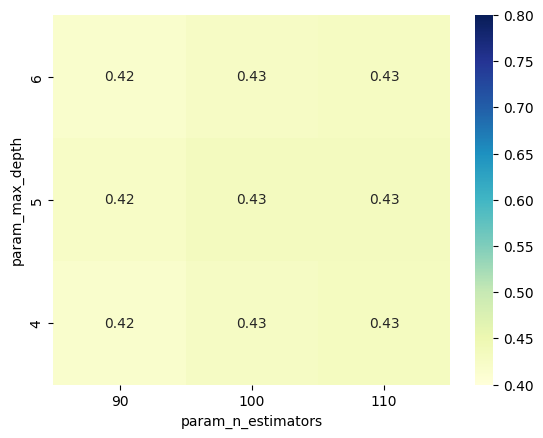

In [30]:
import seaborn as sns

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.4,
                 vmax=0.8)
ax.invert_yaxis()

In [31]:
#run XGBoost model
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

gbrt_pipeline = xgb.XGBRegressor(learning_rate=0.05,n_estimators=100,max_depth=5)

evaluate(gbrt_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     2.622 +/- 0.496
Root Mean Squared Error: 3.780 +/- 0.797


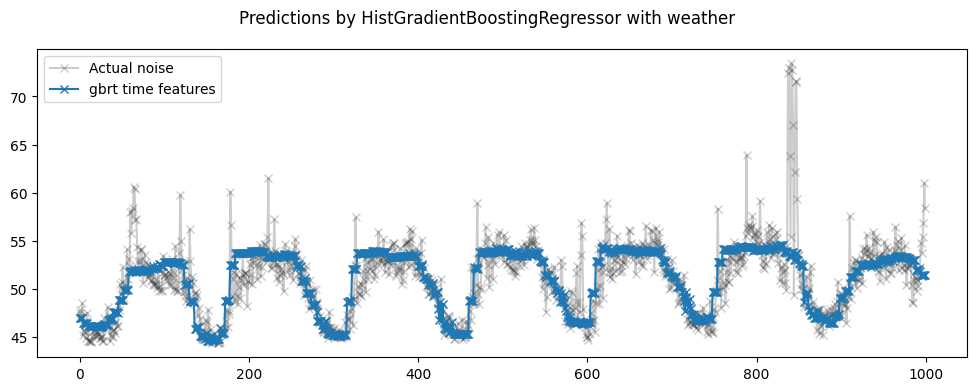

In [34]:
#Qualitative analysis of the impact of features on linear model predictions
gbrt_pipeline.fit(X, y)
gbrt_predictions = gbrt_pipeline.predict(X)

last_hours = slice(-1000, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by HistGradientBoostingRegressor with weather")
ax.plot(
    y.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual noise",
    color="black",
)
ax.plot(gbrt_predictions[last_hours], "x-", label="gbrt time features")
_ = ax.legend()


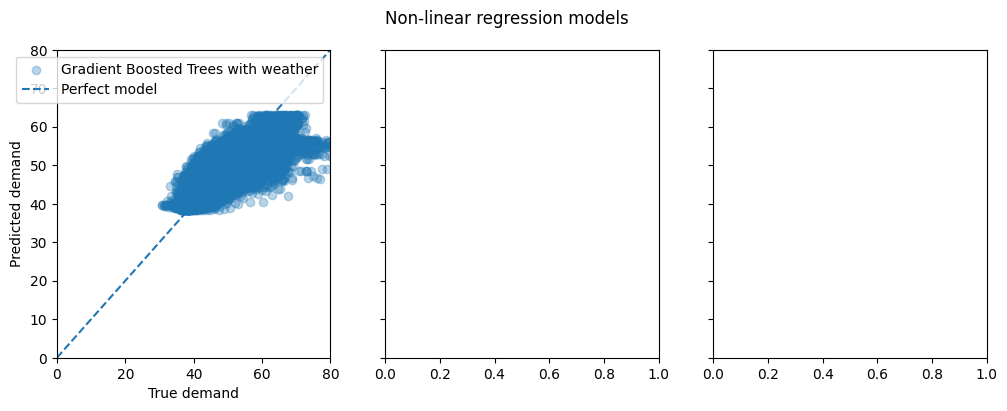

In [35]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    gbrt_predictions,
]
labels = [
    "Gradient Boosted Trees with weather",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.values, pred, alpha=0.3, label=label)
    ax.plot([0, 80], [0, 80], "--", label="Perfect model")
    ax.set(
        xlim=(0, 80),
        ylim=(0, 80),
        xlabel="True demand",
        ylabel="Predicted demand",
    )
    ax.legend()

plt.show()

In [25]:
#now do the same but look at variables separately: 
# the feature importance should be lower, because dropping a variable form the model 
# will not result in a large decrease of information gain, etc if the other correlated variables take over the task of explaining the model 
#example: you can see that weekend is not as important anymore, because day takes over if weekend is in the model
features=['hour','weekday','month','weekend','holiday','exam_period','LC_HUMIDITY','LC_DWPTEMP','LC_n',
          'LC_RAD','LC_RAININ','LC_DAILYRAIN','LC_WINDDIR','LC_WINDSPEED','LC_RAD60','LC_TEMP_QCL0']
imp = importances(gbrt_pipeline, X, y, features=features) # permutation
#should be on fitted model. I used the X and y but usualy you would need to use the validation set
viz = plot_importances(imp)
viz.view()

NameError: name 'importances' is not defined